In [1]:
# import autosklearn.classification
from pipeline import *

# pipeline_year(10)

df_coaches = pd.read_csv('dataset/cleaned/coaches.csv')
l = []
clf = RandomForestClassifier(n_estimators=100, random_state=42)
decay_rate=0.1
df_teams_merged = []
test = []
train = []
year = 10
for i in range(2, year + 1):
    df_teams_merged = pipeline_clf(year=i)
    weight = decay_rate ** (10 - i - 1)

    df_teams_merged['confID'] = df_teams_merged['confID'].replace({'EA': 0, 'WE': 1})

    train = df_teams_merged[df_teams_merged['year'] < i]
    test = df_teams_merged[df_teams_merged['year'] == i]

    if (year == i):
        break

    X_train = train[train.drop(['playoff', 'year', 'tmID'], axis=1).columns]
    y_train = train['playoff']
    sample_weight = [weight] * len(X_train)

    clf.fit(X_train, y_train, sample_weight=sample_weight)

predictions = clf.predict_proba(test.drop(['playoff', 'year', 'tmID'], axis=1))[:, 1]
test['predictions'] = predictions
df_teams_merged['predictions'] = 0
df_teams_merged.loc[df_teams_merged['year'] == year, 'predictions'] = predictions

df_teams_merged['confID'] = df_teams_merged['confID'].replace({0: 'EA', 1 : 'WE'})

# print the year and the predicted scores
print(df_teams_merged[df_teams_merged['year'] == year][['tmID', 'confID', 'predictions', 'awards', 'offensive_strength']].sort_values(by='predictions', ascending=False))


df_teams, ea_teams, we_teams = classify_playoff_entry(
        df_teams_merged, year)

ea_predictions = ea_teams['tmID'].unique()
we_predictions = we_teams['tmID'].unique()


accuracy = calculate_playoff_accuracy(
    year, ea_predictions, we_predictions, display_results = True)

print(l)


c:\Users\ricar\OneDrive\Ambiente de Trabalho\ac\funcs\statistical_analysis.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_coaches['win_percentage_coach'] = (df_coaches['won'] + df_coaches['post_wins']) / (df_coaches['won'] +
c:\Users\ricar\OneDrive\Ambiente de Trabalho\ac\funcs\statistical_analysis.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_coaches['win_percentage_coach'] = (df_coaches['won'] + df_coaches['post_wins']) / (df_coaches['won'] +
c:\Users\ricar\OneDrive\Ambiente de Trabal

    tmID confID  predictions  awards  offensive_strength
62   LAS     WE         0.96      16            1.412521
33   DET     EA         0.85       8            1.537025
128  SEA     WE         0.75       5            0.889918
98   PHO     WE         0.65       4            0.818771
118  SAS     WE         0.62       2            1.218628
23   CON     EA         0.58       0            0.491682
52   IND     EA         0.56       9            1.094342
1    ATL     EA         0.48       5            0.577290
85   NYL     EA         0.42       1            0.125098
111  SAC     WE         0.37       1            0.640735
141  WAS     EA         0.20       0            0.308563
12   CHI     EA         0.19       1            0.214965
75   MIN     WE         0.11       3            0.135759


Year:               10
WE
Guesses:       LAS, SEA, PHO, SAS, 
Missed:        
EA
Guesses:       DET, IND, ATL, CON
Missed:        WAS
Total accuracy:     87.50%

[]


C:\Users\ricar\AppData\Local\Temp\ipykernel_19712\1353428350.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] = predictions


In [2]:
pipeline_year(8,display_results=True)

c:\Users\ricar\OneDrive\Ambiente de Trabalho\ac\funcs\statistical_analysis.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_coaches['win_percentage_coach'] = (df_coaches['won'] + df_coaches['post_wins']) / (df_coaches['won'] +
c:\Users\ricar\OneDrive\Ambiente de Trabalho\ac\pipeline.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['confID'] = train['confID'].replace(['EA', 'WE'], [0, 1])
c:\Users\ricar\OneDrive\Ambiente de Trabalho\ac\pipeline.py:142: SettingWithCopyWarning: 
A value is t



Year:               8
WE
Guesses:       SEA, PHO, LAS, HOU
Missed:        SAS, SAC
EA
Guesses:       DET, CON, IND, WAS
Missed:        NYL
Total accuracy:     62.50%



c:\Users\ricar\OneDrive\Ambiente de Trabalho\ac\pipeline.py:212: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] = predictions


62.5

c:\Users\ricar\OneDrive\Ambiente de Trabalho\ac\funcs\statistical_analysis.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_coaches['win_percentage_coach'] = (df_coaches['won'] + df_coaches['post_wins']) / (df_coaches['won'] +
c:\Users\ricar\OneDrive\Ambiente de Trabalho\ac\pipeline.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['confID'] = train['confID'].replace(['EA', 'WE'], [0, 1])
c:\Users\ricar\OneDrive\Ambiente de Trabalho\ac\pipeline.py:142: SettingWithCopyWarning: 
A value is t

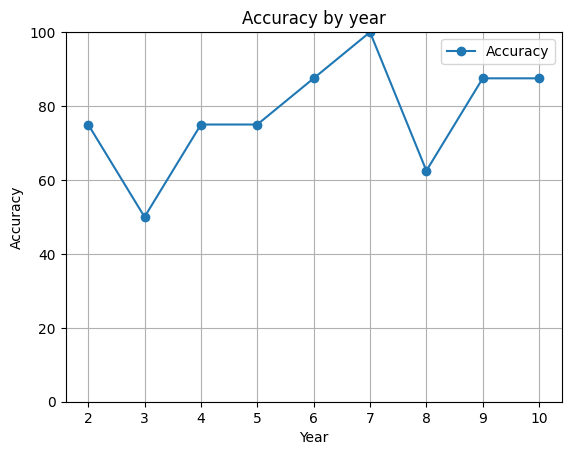

In [3]:
from pipeline import *

def check_accuracy_by_year2():
    accs = []
    years = list(range(2, 11))

    for year in years:
        acc = pipeline_year(year)
        accs.append(acc)

    # plot the accuracy line graph
    plt.plot(years, accs, label="Accuracy", marker='o', linestyle='-')

    # add labels for each data point
    # for i, acc in enumerate(accs):
      #  plt.text(years[i], acc, f"{acc:.2f}", ha="center", va="bottom")

    # add legend
    plt.legend()

    # set Y-axis limits
    plt.ylim(0, 100)

    plt.xlabel("Year")
    plt.ylabel("Accuracy")
    plt.title("Accuracy by year")
    plt.grid(True)

    plt.show()

check_accuracy_by_year2()